In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt

from joblib import load
from datetime import datetime

2025-10-23 23:11:09.962611: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-23 23:11:10.030271: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-23 23:11:10.376389: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-23 23:11:12.133716: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
SEED = 42
EPOCHS = 15
BATCH  = 32

tf.keras.utils.set_random_seed(SEED)

In [3]:
ARTIFACTS_DIR = "../artifacts"

MODEL_NAME = f"cnn_batchnorm"

INPUT_FILE = os.path.join(ARTIFACTS_DIR, "images_tuple.joblib")

LOG_DIR   = os.path.join(ARTIFACTS_DIR, "logs", f"{MODEL_NAME}")
MODEL_FILE = os.path.join(ARTIFACTS_DIR, f"{MODEL_NAME}.keras")
CKPT_FILE  = os.path.join(ARTIFACTS_DIR, f"best_{MODEL_NAME}.keras")

In [4]:
(
    X_train, X_val, X_test,
    y_train, y_val, y_test,
    classes
) = load(INPUT_FILE)

num_classes = len(classes)
print("Classes:", classes)
print("Train shape:", X_train.shape, y_train.shape)

Classes: ['az', 'dobro', 'estb', 'frbtb', 'ize', 'jatb', 'ljudie', 'nasb', 'sa', 'sta', 'ukb', 'vede']
Train shape: (900, 128, 128, 4) (900, 12)


In [21]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=X_train.shape[1:]),
    
    tf.keras.layers.Resizing(64, 64),
    tf.keras.layers.Rescaling(1.0 / 255),
    
    tf.keras.layers.Conv2D(32, (3,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.1),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.1),
    
    tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()],
)

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_5 (Resizing)           │ (None, 64, 64, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_5 (Rescaling)         │ (None, 64, 64, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 62, 62, 32)     │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 30752)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │     1,968,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,970,284 (7.52 MB)

 Trainable params: 1,970,220 (7.52 MB)

 Non-trainable params: 64 (256.00 B)

In [22]:
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=3, restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        CKPT_FILE, monitor="val_categorical_accuracy", save_best_only=True
    )
]

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc:.4f}")

Epoch 1/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - categorical_accuracy: 0.2368 - loss: 5.2203 - val_categorical_accuracy: 0.1977 - val_loss: 2.3823
Epoch 2/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - categorical_accuracy: 0.5658 - loss: 1.1848 - val_categorical_accuracy: 0.1589 - val_loss: 2.3176
Epoch 3/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - categorical_accuracy: 0.6432 - loss: 0.8946 - val_categorical_accuracy: 0.3372 - val_loss: 2.0177
Epoch 4/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - categorical_accuracy: 0.7290 - loss: 0.7556 - val_categorical_accuracy: 0.5736 - val_loss: 1.6322
Epoch 5/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - categorical_accuracy: 0.7777 - loss: 0.5686 - val_categorical_accuracy: 0.6667 - val_loss: 1.2637
Epoch 6/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - categorical_accuracy: 0.8365 - loss: 0.4667 - val_categorical_accuracy: 0.7054 - val_loss: 1.1723
Epoch 7/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - categorical_accuracy: 0.8344 - loss: 

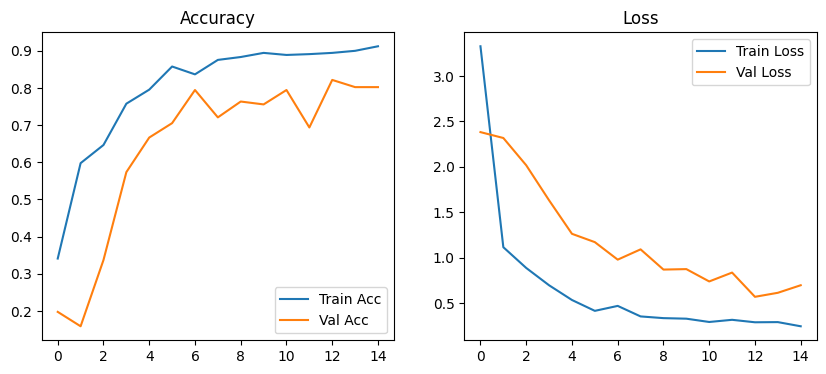

In [23]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history['categorical_accuracy'], label='Train Acc')
plt.plot(history.history['val_categorical_accuracy'], label='Val Acc')
plt.title('Accuracy'); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss'); plt.legend()

plt.show()

In [24]:
model.save(MODEL_FILE)
print(f"Saved model to {MODEL_FILE}")

Saved model to ../artifacts/cnn_batchnorm.keras
